## _PandaML_
- Perform detailed _Exploratory Data Analysis_ (EDA) on STT Data.

In [1]:
import sys, os, glob, yaml

In [2]:
import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trackml.dataset
import seaborn as sns

In [4]:
sys.path.append('src')

### _Dataset_

In [5]:
# mu- data (old)
# input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (current)
input_dir = './data_sets/pandaml/data_0.1_1.5_GeV/'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [6]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [7]:
file_prefixes[:10]

['./data_sets/pandaml/data_0.1_1.5_GeV/event0000000000',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000001',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000002',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000003',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000004',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000005',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000006',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000007',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000008',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000009']

In [8]:
event_id = 0
event_prefix = file_prefixes[event_id]

In [9]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000000 memory usage 0.03 MB


In [10]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-14.869700,-10.605,35.0,9,0,38
1,2,-15.744300,-11.110,35.0,9,1,144
2,3,-16.618999,-11.615,35.0,9,2,256
3,4,-17.493700,-12.120,35.0,9,3,374
4,5,-18.368401,-12.625,35.0,9,4,498


In [11]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.034734,15204100.0,15.2041,9,0,38,0,2
1,2,0.048140,25058700.0,25.0587,9,1,144,0,2
2,3,0.055623,13596100.0,13.5961,9,2,256,0,2
3,4,0.046304,12138100.0,12.1381,9,3,374,0,2
4,5,0.009433,26845900.0,26.8459,9,4,498,0,2


In [12]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,0.417332,0.938952,-0.457557,1,25,13,0
1,2,0.0,0.0,0.0,-0.493657,-0.352344,0.712380,1,24,13,0
2,3,0.0,0.0,0.0,-0.166948,0.059120,0.264588,1,26,13,0
3,4,0.0,0.0,0.0,0.573950,0.219286,-0.417693,1,22,13,0
4,5,0.0,0.0,0.0,-0.296571,0.510891,0.733194,1,26,13,0


In [13]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-14.852000,-10.6347,43.741699,-0.273197,-0.162639,0.765421,1.0,10
1,2,-15.722200,-11.1478,46.171398,-0.274899,-0.160593,0.765203,1.0,10
2,3,-16.597000,-11.6535,48.600101,-0.276364,-0.157971,0.765186,1.0,10
3,4,-17.476700,-12.1505,51.029800,-0.277693,-0.155004,0.765268,1.0,10
4,5,-18.360901,-12.6388,53.460499,-0.279028,-0.152464,0.765253,1.0,10


### _Detector Layout_

In [14]:
def draw_single_event(event=None, event_id=9999, name="event", figsize=(10, 10), save_fig=False):
    """Draw a Single Event"""
    p_ids = np.unique(particles.particle_id.values)
    det = pd.read_csv("src/stt.csv")
    # plt.style.use('seaborn')
    # fig = plt.gcf()
    fig = plt.figure(figsize=figsize)
    skw = det.query('skewed==0')
    nkw = det.query('skewed==1')
    plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
    plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')
    for i in p_ids:
        df_ = hits.loc[truth.particle_id == i]
        plt.scatter(df_.x.values, df_.y.values, s=(tubes.loc[truth.particle_id == i].isochrone*100).values, label='particle_id: %d' % i)
    plt.title('Event ID # %d' % event_id)
    plt.xlabel('x [cm]', fontsize=10)
    plt.ylabel('y [cm]', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim((-41, 41))
    plt.ylim((-41, 41))
    plt.grid(False)
    plt.legend(fontsize=10, loc='best')

    plt.tight_layout()
    if save_fig:
        plt.savefig(name+'_%d.png' % event_id)
    return fig

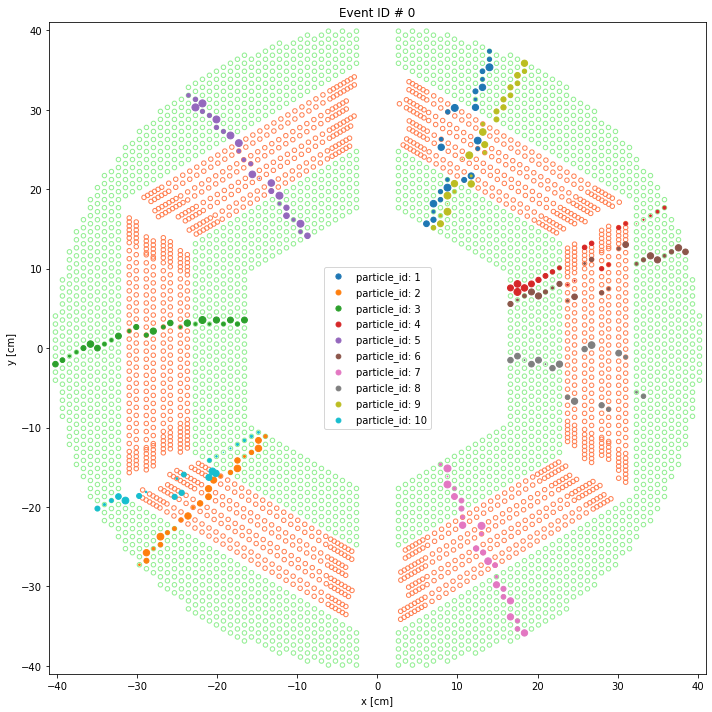

In [15]:
draw_single_event(hits, event_id, "event", (10, 10), False);

### _Draw Tracks_

In [16]:
# preprocess hits
# hits['r'] = hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
hits_ = hits.assign(r=hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1))
hits_.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,r
0,1,-14.869700,-10.605,35.0,9,0,38,18.264008
1,2,-15.744300,-11.110,35.0,9,1,144,19.269537
2,3,-16.618999,-11.615,35.0,9,2,256,20.275585
3,4,-17.493700,-12.120,35.0,9,3,374,21.282010
4,5,-18.368401,-12.625,35.0,9,4,498,22.288759


In [17]:
# we already have sorted hits, lets draw a single track.
data = hits_[truth.particle_id == particles.iloc[1,0]]
data

,hit_id,x,y,z,volume_id,layer_id,module_id,r
191,192,-13.995000,-11.110000,35.0,9,0,39,17.868747
192,193,-14.869700,-11.615000,35.0,9,1,145,18.868392
193,194,-14.869700,-12.625000,35.0,9,2,258,19.506374
194,195,-15.744300,-13.130000,35.0,9,3,376,20.500729
195,196,-16.618999,-13.635000,35.0,9,4,500,21.496613
196,197,-17.493700,-14.140000,35.0,9,5,630,22.493758
197,198,-17.493700,-15.150000,35.0,9,6,767,23.141997
198,199,-18.368401,-15.655000,35.0,9,7,909,24.134564
199,200,-19.594601,-16.113300,35.0,9,8,1066,25.369013
200,201,-20.469900,-16.617901,35.0,9,9,1262,26.366104


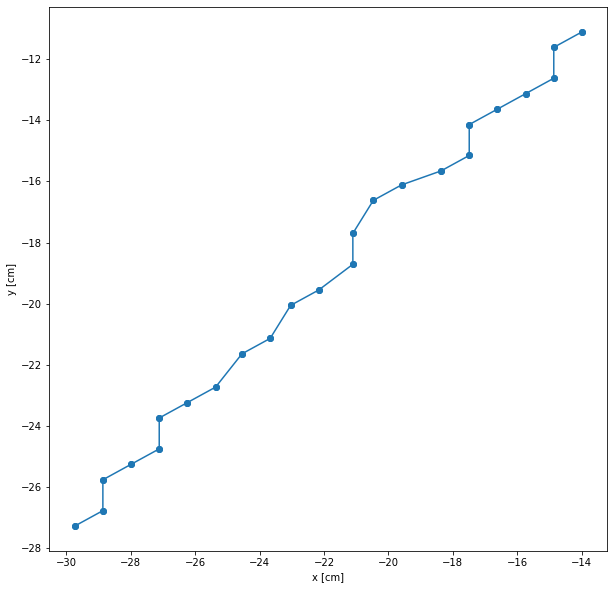

In [18]:
# Using Object Oriented API
plt.close('all')
plt.figure(figsize=(10,10))
plt.scatter(data.x.values, data.y.values)
plt.plot(data.x.values, data.y.values, "-o")
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
#plt.xlim(-40, 40)
#plt.ylim(-40, 40)
# plt.savefig(os.path.join(outdir, "event.png"))
plt.show()

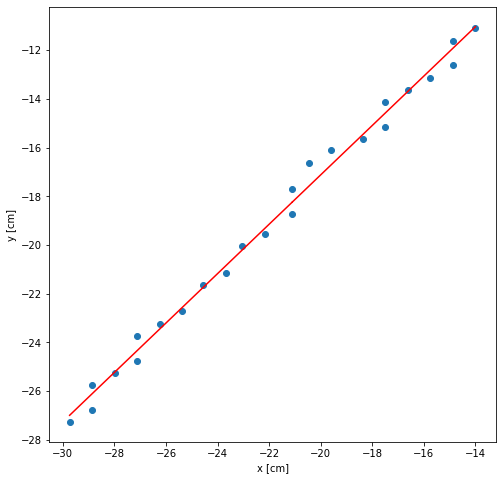

In [19]:
# numpy.polyfit() function
plt.close('all')
plt.figure(figsize=(8,8))

a, b = np.polyfit(data.x, data.y, 1)

plt.scatter(data.x.values, data.y.values)
plt.plot(data.x.values, a*data.x.values+b, 'r')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
#plt.xlim((5, 40))
#plt.ylim((5, 40))
plt.show()

### _Momentum Distributions_

In [20]:
# calculate & assign pt
particles = particles.assign(pt=np.sqrt(particles.px**2 + particles.py**2))

In [21]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,pt
0,1,0.0,0.0,0.0,0.417332,0.938952,-0.457557,1,25,13,0,1.027520
1,2,0.0,0.0,0.0,-0.493657,-0.352344,0.712380,1,24,13,0,0.606501
2,3,0.0,0.0,0.0,-0.166948,0.059120,0.264588,1,26,13,0,0.177107
3,4,0.0,0.0,0.0,0.573950,0.219286,-0.417693,1,22,13,0,0.614414
4,5,0.0,0.0,0.0,-0.296571,0.510891,0.733194,1,26,13,0,0.590732


In [22]:
particles.pt

0    1.027520
1    0.606501
2    0.177107
3    0.614414
4    0.590732
5    1.392711
6    1.035057
7    0.232231
8    0.817033
9    0.323897
Name: pt, dtype: float32

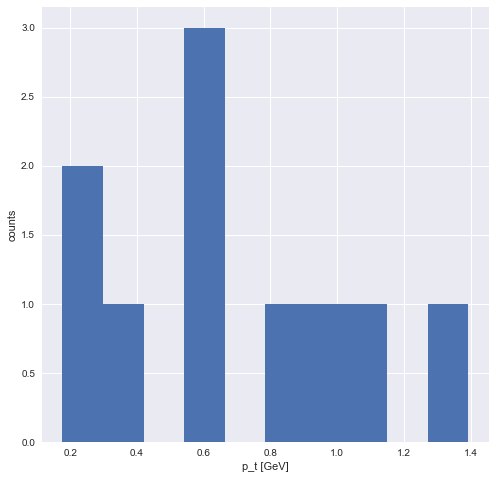

In [23]:
plt.close('all')
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,8))

plt.hist(particles.pt, bins=10)

plt.xlabel('p_t [GeV]')
plt.ylabel('counts')
# plt.xlim((0.1, 1.5))
#plt.ylim((5, 40))
plt.show()

In [24]:
# find average hits per track
print("Average number of hits per tracks: {}".format(hits.hit_id.count()/particles.particle_id.unique().size))

Average number of hits per tracks: 24.0
